# Histopathologic Cancer Detection Using CNN and Pretrained Image classification Models

## Introduction

In this project, I am using a Deep Learning Technique known as Convolutional Neural Networks (CNN) to create a model that can identify cancer from medical images. My approach involves using the ResNet50V2, a powerful model that has already been trained on a large collection of images called ImageNet, to boost the model's speed and accuracy in spotting brain tumors.

## Data Source

The images I used for this project come from the  "[Histopathologic Cancer Dataset](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)" hosted on Kaggle. This dataset contains several MRI scans of brains, which are crucial for recognizing brain tumors.
## Setting Up the Model

### Importing Libraries and Setting Parameters


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow.keras.layers as L
from tensorflow.keras.layers import * 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Helper Functions

In [2]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# Load Training DataFrame

In [3]:
train = pd.read_csv('../Cancer-Detection/train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [4]:
# Check the data labels
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
# Add the filetype to the labels
train.id = train.id + '.tif'

In [6]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


# Label Distribution

In [7]:
# Check the label distribution
(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


# Extract Images

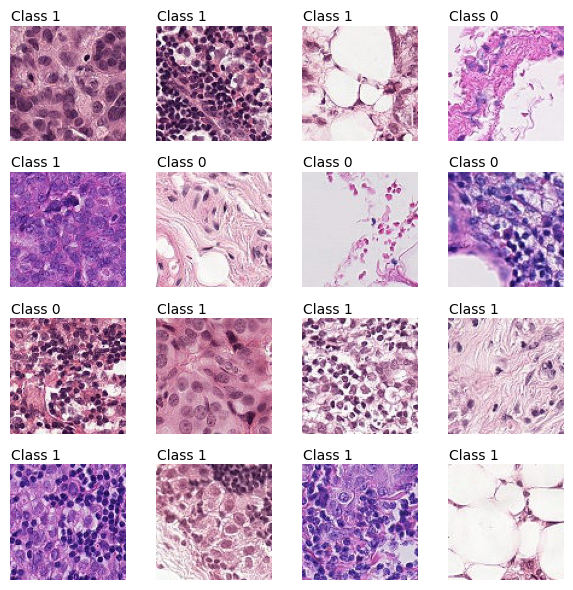

In [8]:
train_path = "../Cancer-Detection/train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'../Cancer-Detection/train/{row.id}')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

# Training and Validation Sets

In [9]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

# Data Generators

In [10]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

Found 44005 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [12]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

688
688


In [13]:
# Using GPU Mixed Precision to accelerate training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


# Load Base Model

In [83]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(96,96,3), 
    include_top=False, 
    weights='imagenet'
)

#base_model.trainable = False

base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 50, 50, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [84]:
#Adjust image size and seed for model training
image_size = (96, 96)
Seed = 42

# Build and Train

In [85]:
np.random.seed(Seed)
tf.random.set_seed(Seed)

cnn = Sequential([
    base_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 batch_normalization_7 (Batc  (None, 3, 3, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_12 (Dense)            (None, 16)                294928    
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_8 (Batc  (None, 16)               64        
 hNormalization)                                      

In [86]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
    )
]

In [87]:
opt = tf.keras.optimizers.Adam()
cnn.compile(loss=keras.losses.BinaryFocalCrossentropy(), optimizer=opt, metrics=['accuracy'])

In [88]:
%%time 

h1 = cnn.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 30,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    #verbose = 1,
    callbacks=callbacks
)

Epoch 1/30
688/688 [==============================] - 72s 95ms/step - loss: 0.1560 - accuracy: 0.7360 - val_loss: 0.1252 - val_accuracy: 0.7677 - lr: 0.0010
Epoch 2/30
688/688 [==============================] - 66s 96ms/step - loss: 0.1413 - accuracy: 0.7555 - val_loss: 0.3858 - val_accuracy: 0.6362 - lr: 0.0010
Epoch 3/30
688/688 [==============================] - 66s 96ms/step - loss: 0.1258 - accuracy: 0.7792 - val_loss: 0.1718 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 4/30
688/688 [==============================] - 65s 95ms/step - loss: 0.1096 - accuracy: 0.7944 - val_loss: 0.0956 - val_accuracy: 0.8322 - lr: 0.0010
Epoch 5/30
688/688 [==============================] - 65s 94ms/step - loss: 0.0994 - accuracy: 0.8166 - val_loss: 0.1308 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 6/30
688/688 [==============================] - 65s 95ms/step - loss: 0.0839 - accuracy: 0.8761 - val_loss: 0.0951 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 7/30
688/688 [==============================] - 64s 

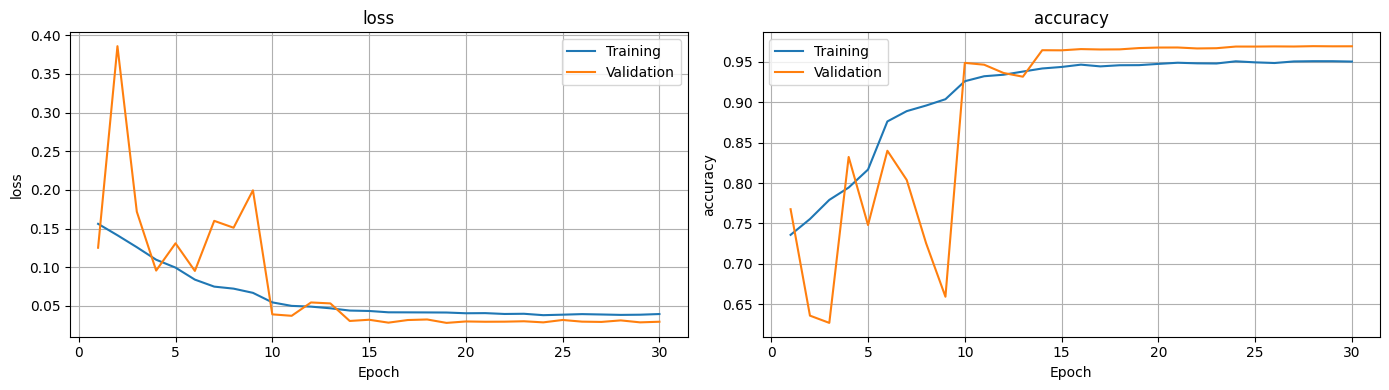

In [104]:
history = merge_history([h1])
vis_training(history)

## Training Accuracy - 95.01%
## Validatin Accuracy - 96.90%

In [105]:
cnn.save('HCDv01.h5')
pickle.dump(history, open(f'HCDv01.pkl', 'wb'))

# Submission

In [106]:
test = pd.read_csv('../Cancer-Detection/sample_submission.csv')

print('Test Set Size:', test.shape)

Test Set Size: (57458, 2)


In [107]:
test['filename'] = test.id + '.tif'

In [108]:
test.head()

,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [109]:
test_path = "../Cancer-Detection/test"
print('Test Images:', len(os.listdir(test_path)))

Test Images: 57458


In [110]:
BATCH_SIZE = 64

test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


In [111]:
test_probs = cnn.predict(test_loader)
print(test_probs.shape)

898/898 [==============================] - 31s 34ms/step
(57458, 2)


In [112]:
print(len(test_loader))

898


In [113]:
print(test_probs[:10,].round(2))

[[0.89 0.11]
 [0.84 0.15]
 [0.83 0.17]
 [0.88 0.12]
 [0.96 0.04]
 [0.12 0.88]
 [0.32 0.68]
 [0.34 0.66]
 [0.96 0.04]
 [0.96 0.04]]


In [114]:
test_pred = np.argmax(test_probs, axis=1)
print(test_pred[:10])

[0 0 0 0 0 1 1 1 0 0]


# Prepare Submission

In [115]:
submission = pd.read_csv('../Cancer-Detection/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [116]:
submission.label = test_probs[:,1]
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.110352
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.154663
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.172119
3,2c35657e312966e9294eac6841726ff3a748febf,0.121887
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.036743


In [117]:
submission.to_csv('submission.csv', header=True, index=False)
